In [ ]:
pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-jp8ijnou
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-jp8ijnou
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=51d5f23cd381882f3ca018149c0b05973488dcf5c79a1097b192f3c2a62f11e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-sk758mdw/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
from matplotlib import image, pyplot
from glob import glob
from numpy import asarray
from skimage.transform import resize as imresize
from PIL import Image
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from __future__ import print_function, division
from google.colab import *
import matplotlib.pyplot as plt
import pickle
import os
import urllib
import gzip
import numpy as np
import scipy
import cv2
import tensorflow as tf
import datetime

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Load Data

In [ ]:
categories = ['aeroplane', 'bicycle', 'bus', 'car', 'horse', 'knife', 'motorcycle', 'person', 'plant', 'skateboard', 'train', 'truck', 'other']

Root = "/content/drive/MyDrive/CZ4041 Machine Learning/Actual Dataset Pickle/"


trainX = []
trainY = []
testX = []
testY = []

train_images = []
train_labels = []
target_images = []
target_labels = []


for i in range(len(categories)):
    print("\rLoading {} data".format(categories[i]), end='')
    trainPath = Root + "train_" + categories[i] + ".npz"
    testPath = Root + "test_" + categories[i] + ".npz"
               
    temp = np.load(trainPath)
    trainX=temp['x']
    trainY=temp['y']
               
    temp = np.load(testPath)
    testX=temp['x']
    testY=temp['y']

    for j in range(len(trainX)):
        text = 'Flattening source ' + categories[i] + ' ' + str(j)
        print('\r{}'.format(text), end='')
        train_images.append(trainX[j])
        train_labels.append(trainY[j])
    for k in range(len(testX)):
        text = 'Flattening target ' + categories[i] + ' ' + str(k)
        print('\r{}'.format(text), end='')
        target_images.append(testX[k])
        target_labels.append(testY[k])
        
    



Flattening target other 49746

In [ ]:
len(train_images)

142766

In [ ]:
def Load_data(train_images, train_labels, test_images, test_labels, batchSize):
  idxA = np.random.randint(0, len(train_images), batchSize)
  idxB = np.random.randint(0, len(target_images), batchSize)
  imgs_A = []
  labels_A = []
  imgs_B = []
  labels_B = []

  for i in range(len(idxA)):
    imgs_A.append(train_images[idxA[i]])
    labels_A.append(train_labels[idxA[i]])
  
  for j in range(len(idxB)):
    imgs_B.append(test_images[idxB[j]])
    labels_B.append(test_labels[idxB[j]])

  imgs_A = np.asarray(imgs_A)
  labels_A = np.asarray(labels_A)
  imgs_B = np.asarray(imgs_B)
  labels_B = np.asarray(labels_B)

  return imgs_A, labels_A, imgs_B, labels_B

#imgs_B, labels_B = test_images[idx], test_labels[idx]

In [ ]:
simg, slabel, timg, tlabels = Load_data(train_images, train_labels, target_images, target_labels, 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


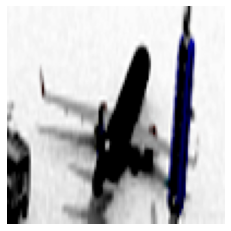

In [ ]:
pyplot.axis('off')
pyplot.imshow(simg[0])
pyplot.show()

In [ ]:
##physical_devices = tf.config.experimental.list_physical_devices('GPU')
##assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
##config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

class PixelDA():
    def __init__(self):
        # Input shape
        self.img_rows = 100
        self.img_cols = 100
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 13

        # Configure MNIST and MNIST-M data loader
        #self.data_loader = DataLoader(img_res=(self.img_rows, self.img_cols))# can remove

        # Loss weights
        lambda_adv = 13
        lambda_clf = 1

        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (7, 7, 1)

        # Number of residual blocks in the generator
        self.residual_blocks = 6

        optimizer = Adam(0.0002, 0.5)

        # Number of filters in first layer of discriminator and classifier
        self.df = 64
        self.cf = 64

        # Build and compile the discriminators
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # Build the task (classification) network
        self.clf = self.build_classifier()

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Translate images from domain A to domain B
        fake_B = self.generator(img_A)

        # Classify the translated image
        class_pred = self.clf(fake_B)

        # For the combined model we will only train the generator and classifier
        self.discriminator.trainable = False

        # Discriminator determines validity of translated images
        valid = self.discriminator(fake_B)

        self.combined = Model(img_A, [valid, class_pred])
        self.combined.compile(loss=['mse', 'categorical_crossentropy'],
                                    loss_weights=[lambda_adv, lambda_clf],
                                    optimizer=optimizer,
                                    metrics=['accuracy'])
        #self.discriminator.summary()
        #self.combined.summary()

    def build_generator(self):
        """Resnet Generator"""

        def residual_block(layer_input):
            """Residual block described in paper"""
            d = Conv2D(64, kernel_size=3, strides=1, padding='same')(layer_input)
            d = BatchNormalization(momentum=0.8)(d)
            d = Activation('relu')(d)
            d = Conv2D(64, kernel_size=3, strides=1, padding='same')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Add()([d, layer_input])
            return d

        # Image input
        img = Input(shape=self.img_shape)

        l1 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(img)

        # Propogate signal through residual blocks
        r = residual_block(l1)
        for _ in range(self.residual_blocks - 1):
            r = residual_block(r)

        output_img = Conv2D(self.channels, kernel_size=3, padding='same', activation='tanh')(r)

        return Model(img, output_img)


    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, normalization=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d

        img = Input(shape=self.img_shape)

        d1 = d_layer(img, self.df, normalization=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity)

    def build_classifier(self):

        def clf_layer(layer_input, filters, f_size=4, normalization=True):
            """Classifier layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d

        img = Input(shape=self.img_shape)

        c1 = clf_layer(img, self.cf, normalization=False)
        c2 = clf_layer(c1, self.cf*2)
        c3 = clf_layer(c2, self.cf*4)
        c4 = clf_layer(c3, self.cf*8)
        c5 = clf_layer(c4, self.cf*8)

        class_pred = Dense(self.num_classes, activation='softmax')(Flatten()(c5))

        return Model(img, class_pred)

    def train(self, epochs, batch_size=128, sample_interval=50):

        half_batch = int(batch_size / 2)

        # Classification accuracy on 100 last batches of domain B
        test_accs = []

        # Adversarial ground truths
        valid = np.ones((batch_size, *self.disc_patch))
        fake = np.zeros((batch_size, *self.disc_patch))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            imgs_A, labels_A, imgs_B, labels_B = Load_data(train_images, train_labels, target_images, target_labels, batch_size)
            imgs_A = imgs_A/127.5 - 1
            imgs_B = imgs_B/127.5 - 1

            #imgs_A, labels_A = self.data_loader.load_data(domain="A", batch_size=batch_size)#change to use actual dataset, need to check original format of this first
            #imgs_B, labels_B = self.data_loader.load_data(domain="B", batch_size=batch_size)#change to use actual dataset, need to check original format of this first

            # Translate images from domain A to domain B
            fake_B = self.generator.predict(imgs_A)

            # Train the discriminators (original images = real / translated = Fake)
            d_loss_real = self.discriminator.train_on_batch(imgs_B, valid)
            d_loss_fake = self.discriminator.train_on_batch(fake_B, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # --------------------------------
            #  Train Generator and Classifier
            # --------------------------------

            # One-hot encoding of labels
            labels_A = to_categorical(labels_A, num_classes=self.num_classes)

            # Train the generator and classifier
            g_loss = self.combined.train_on_batch(imgs_A, [valid, labels_A])

            #-----------------------
            # Evaluation (domain B)
            #-----------------------

            pred_B = self.clf.predict(imgs_B)
            test_acc = np.mean(np.argmax(pred_B, axis=1) == labels_B)

            # Add accuracy to list of last 100 accuracy measurements
            test_accs.append(test_acc)
            if len(test_accs) > 100:
                test_accs.pop(0)


            # Plot the progress
            print ( "%d : [D - loss: %.5f, acc: %3d%%], [G - loss: %.5f], [clf - loss: %.5f, acc: %3d%%, test_acc: %3d%% (%3d%%)]" % \
                                            (epoch, d_loss[0], 100*float(d_loss[1]),
                                            g_loss[1], g_loss[2], 100*float(g_loss[-1]),
                                            100*float(test_acc), 100*float(np.mean(test_accs))))


            # If at save interval => save generated image samples
            checkpointPath= '/content/drive/MyDrive/CZ4041 Machine Learning/'
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
                self.discriminator.save(checkpointPath+"PixelDiscriminator")
                self.combined.save(checkpointPath+"PixelCombined")

    def sample_images(self, epoch):
        r, c = 2, 5

        imgs_A, _ , _ , _= Load_data(train_images, train_labels, target_images, target_labels, 5)
        imgs_A = imgs_A/127.5 - 1

        # Translate images to the other domain
        fake_B = self.generator.predict(imgs_A)

        gen_imgs = np.concatenate([imgs_A, fake_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        #titles = ['Original', 'Translated']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                #axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("/content/drive/MyDrive/CZ4041 Machine Learning/PixelDA sample images/%d.png" % (epoch))
        plt.close()



In [ ]:
if __name__ == '__main__':
    gan = PixelDA()
    gan.train(epochs=30000, batch_size=16, sample_interval=500)

Streaming output truncated to the last 5000 lines.
25018 : [D - loss: 0.03954, acc:  99%], [G - loss: 0.13651], [clf - loss: 0.41119, acc:  93%, test_acc:  62% ( 72%)]
25019 : [D - loss: 0.04852, acc:  99%], [G - loss: 0.29946], [clf - loss: 0.75026, acc:  68%, test_acc:  62% ( 72%)]
25020 : [D - loss: 0.06919, acc:  91%], [G - loss: 0.44709], [clf - loss: 0.77567, acc:  75%, test_acc:  75% ( 72%)]
25021 : [D - loss: 0.05346, acc:  96%], [G - loss: 0.53634], [clf - loss: 0.44429, acc:  75%, test_acc:  68% ( 72%)]
25022 : [D - loss: 0.04204, acc:  99%], [G - loss: 0.11382], [clf - loss: 0.24086, acc:  87%, test_acc:  75% ( 72%)]
25023 : [D - loss: 0.08587, acc:  91%], [G - loss: 0.39546], [clf - loss: 0.46778, acc:  81%, test_acc:  81% ( 71%)]
25024 : [D - loss: 0.03886, acc: 100%], [G - loss: 0.44098], [clf - loss: 1.20565, acc:  56%, test_acc:  75% ( 72%)]
25025 : [D - loss: 0.02585, acc: 100%], [G - loss: 0.47071], [clf - loss: 0.47022, acc:  81%, test_acc:  62% ( 71%)]
25026 : [D - 